# fNIRS Hyperscanning study preparation for analysis

Author: Patrice Fortin

Date: 2025-01-06

The following Jupyter Notebook shows how to go from raw fNIRS hyperscanning recordings to produce an output file suitable for statistical analysis of Inter-Brain Synchrony (IBS).

The output file can be of `.csv` or `.feather`. 

For an analysis example in `R` language, see `tutorial/fnirs_study_example.R`.

For an in-depth exploration of wavelet transforms, see `tutorial/wavelet_exploration.ipynb`

For an complete walkthrough of fnirs data inspection at every step, see `tutorial/fnirs_recording_inspection.ipynb`


## Load libraries

In [9]:
import re
from collections import OrderedDict, defaultdict
import matplotlib.pyplot as plt

In [ ]:
%load_ext IPython.extensions.autoreload
%autoreload 2

import hypyp.fnirs as fnirs
from hypyp.wavelet import ComplexMorletWavelet
from hypyp.utils import Task, TASK_NEXT_EVENT

The IPython.extensions.autoreload extension is already loaded. To reload it, use:
  %reload_ext IPython.extensions.autoreload


## Download and load raw data from disk

To use as example, we download the dataset "Dataset of parent-child hyperscanning fNIRS recordings" from https://researchdata.ntu.edu.sg/dataset.xhtml?persistentId=doi:10.21979/N9/35DNCW


In [11]:
browser = fnirs.DataBrowser()
dir = browser.download_demo_dataset()


Prepare dyads paths (parent+child) for file loading

In [12]:
# Get the paths for dyads

paths = [path for path in browser.list_all_files() if 'fathers' in path]

dyad_paths = defaultdict(dict)

for path in paths:
    m = re.search(r'(FCS\d\d)', path)
    dyad_label = m.group(1)

    if 'child' in path:
        dyad_paths[dyad_label]['child'] = path

    if 'parent' in path:
        dyad_paths[dyad_label]['parent'] = path

print(dyad_paths)


defaultdict(<class 'dict'>, {'FCS01': {'child': '/home/pfortin/work/ppsp/HyPyP-synchro/data/NIRS/downloads/fathers/FCS01/child/NIRS-2019-09-28_002.hdr', 'parent': '/home/pfortin/work/ppsp/HyPyP-synchro/data/NIRS/downloads/fathers/FCS01/parent/NIRS-2019-09-28_002.hdr'}, 'FCS02': {'child': '/home/pfortin/work/ppsp/HyPyP-synchro/data/NIRS/downloads/fathers/FCS02/child/NIRS-2019-10-06_004.hdr', 'parent': '/home/pfortin/work/ppsp/HyPyP-synchro/data/NIRS/downloads/fathers/FCS02/parent/NIRS-2019-10-06_004.hdr'}, 'FCS03': {'child': '/home/pfortin/work/ppsp/HyPyP-synchro/data/NIRS/downloads/fathers/FCS03/child/NIRS-2019-10-12_003.hdr', 'parent': '/home/pfortin/work/ppsp/HyPyP-synchro/data/NIRS/downloads/fathers/FCS03/parent/NIRS-2019-10-12_003.hdr'}, 'FCS04': {'child': '/home/pfortin/work/ppsp/HyPyP-synchro/data/NIRS/downloads/fathers/FCS04/child/NIRS-2019-10-12_001.hdr', 'parent': '/home/pfortin/work/ppsp/HyPyP-synchro/data/NIRS/downloads/fathers/FCS04/parent/NIRS-2019-10-12_001.hdr'}, 'FCS05'

## Regions of Interest

Let's define some region of interest, from https://www.nature.com/articles/s41598-019-47810-4 Figure 3.

In [13]:
# dummy values
channel_roi = fnirs.ChannelROI(OrderedDict({
    'frontal_left': [
        'S2_D3 hbo', # 4,
        'S3_D3 hbo', # 6,
        'S3_D4 hbo', # 7,
        'S5_D3 hbo', # 11,
    ],
    'medial_left':[
        'S1_D1 hbo', # 1,
        'S1_D2 hbo', # 2,
        'S2_D1 hbo', # 3,
        'S3_D2 hbo', # 5,
        'S4_D2 hbo', # 8,
    ],
    'central': [
        'S4_D4 hbo', # 9,
        'S5_D4 hbo', # 12,
    ],
    'frontal_right': [
        'S5_D6 hbo', # 13,
        'S6_D4 hbo', # 14,
        'S6_D6 hbo', # 16,
        'S8_D6 hbo', # 19,
    ],
    'medial_right':[
        'S4_D5 hbo', # 10,
        'S6_D5 hbo', # 15,
        'S7_D5 hbo', # 17,
        'S7_D7 hbo', # 18,
        'S8_D7 hbo', # 20
    ],
}))


## One dyad example

As a simple example, let's look at a single inter-subject coherence.

Let's define some task for demonstration of how we can use time based tasks.

Take a look at `fnirs.Recording` constructor if you have event based tasks.

NOTE: The tasks here do not correspond the the actual conditions from the dataset. They are set as an example on how to use the toolbox.

In [50]:
# Get connectivity matrix intra-subject for validation

dyad_label = list(dyad_paths.keys())[0]
dyad_info = list(dyad_paths.values())[0]
tasks = [Task('one_minute', onset_time=0, duration=60)]

# Example if you have tasks from events in the recordings
#tasks = [
#    Task('baseline', onset_event_id=1, offset_event_id=TASK_NEXT_EVENT),
#    Task('task1',    onset_event_id=2, offset_event_id=TASK_NEXT_EVENT),
#    Task('task2',    onset_event_id=3, offset_event_id=TASK_NEXT_EVENT),
#    Task('task3',    onset_event_id=4, offset_event_id=TASK_NEXT_EVENT),
#]

# use a preprocessor to transform the cw amplitude data to hemoglobin concentration
preprocessor = fnirs.MnePreprocessorRawToHaemo()

s1 = fnirs.Recording(tasks=tasks, channel_roi=channel_roi).load_file(dyad_info['child'], preprocessor)
s2 = fnirs.Recording(tasks=tasks, channel_roi=channel_roi).load_file(dyad_info['parent'], preprocessor)

dyad = fnirs.Dyad(s1, s2, label=dyad_label)
dyad.compute_wtcs(
    ch_match='hbo',     # which channels to match
    bin_seconds=15,     # split in bins of 15 seconds
    period_cuts=[5, 10],    # split higher and lower frequencies for comparison
)

dyad.df[['dyad','subject1','subject2','roi1','roi2','channel1','channel2','task','epoch','bin','coherence']]



,dyad,subject1,subject2,roi1,roi2,channel1,channel2,task,epoch,bin,coherence
0,FCS01,FCS01CP,FCS01FP,frontal_left,frontal_left,S2_D3 hbo,S2_D3 hbo,one_minute,0,0,0.269716
1,FCS01,FCS01CP,FCS01FP,frontal_left,frontal_left,S2_D3 hbo,S2_D3 hbo,one_minute,0,1,NaN
2,FCS01,FCS01CP,FCS01FP,frontal_left,frontal_left,S2_D3 hbo,S2_D3 hbo,one_minute,0,2,NaN
3,FCS01,FCS01CP,FCS01FP,frontal_left,frontal_left,S2_D3 hbo,S2_D3 hbo,one_minute,0,3,0.151085
4,FCS01,FCS01CP,FCS01FP,frontal_left,frontal_left,S2_D3 hbo,S2_D3 hbo,one_minute,0,4,0.426708
...,...,...,...,...,...,...,...,...,...,...,...
13003,FCS01FP(intra),FCS01FP,FCS01FP,medial_right,medial_right,S8_D7 hbo,S8_D7 hbo,one_minute,0,7,1.000000
13004,FCS01FP(intra),FCS01FP,FCS01FP,medial_right,medial_right,S8_D7 hbo,S8_D7 hbo,one_minute,0,8,1.000000
13005,FCS01FP(intra),FCS01FP,FCS01FP,medial_right,medial_right,S8_D7 hbo,S8_D7 hbo,one_minute,0,9,1.000000
13006,FCS01FP(intra),FCS01FP,FCS01FP,medial_right,medial_right,S8_D7 hbo,S8_D7 hbo,one_minute,0,10,NaN


**Wavelet Transform Coherence (WTC) details**

Let's take a look at the Wavelet Transform Coherence. We take the first WTC to inspect it.


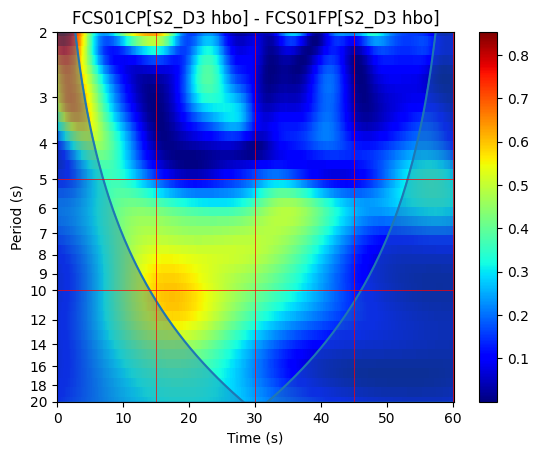

In [51]:
wtc = dyad.wtcs[0]
_ = wtc.plot(use_periods=True)


### Computation validation

In order to be confident in the above results, let's look at intermediary results.

The above Wavelet Transform Coherence (WTC) is a computed from the 2 Continuous Wavelet Transforms (CWT):

Text(0.5, 0.98, 'FCS01CP / FCS01FP')

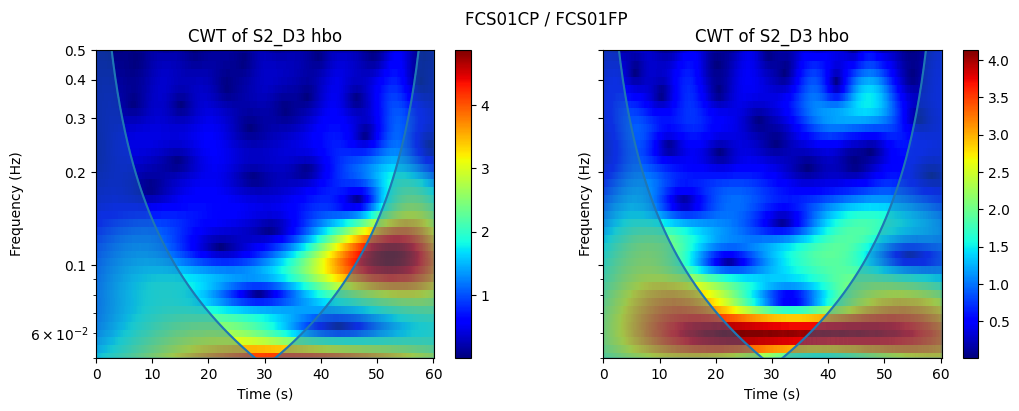

In [37]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
wtc.cwt1.plot(ax=axes[0])
wtc.cwt2.plot(ax=axes[1])
fig.suptitle(f"{dyad.s1.subject_label} / {dyad.s2.subject_label}")


The Continuous Wavelet Transforms (CWTs) come from the hemoglobin that has been computed from the raw cw amplitudes in the signal.

Let's take a look at the original data and its Continuous Wavelet Transform. For more details on visualizing the Continuous 
Wavelet Transform and all the filtering steps, see `fnirs_recording_inspection.ipynb` notebook.


/home/pfortin/work/ppsp/HyPyP-synchro/hypyp/fnirs/recording.py:353: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[j].legend()


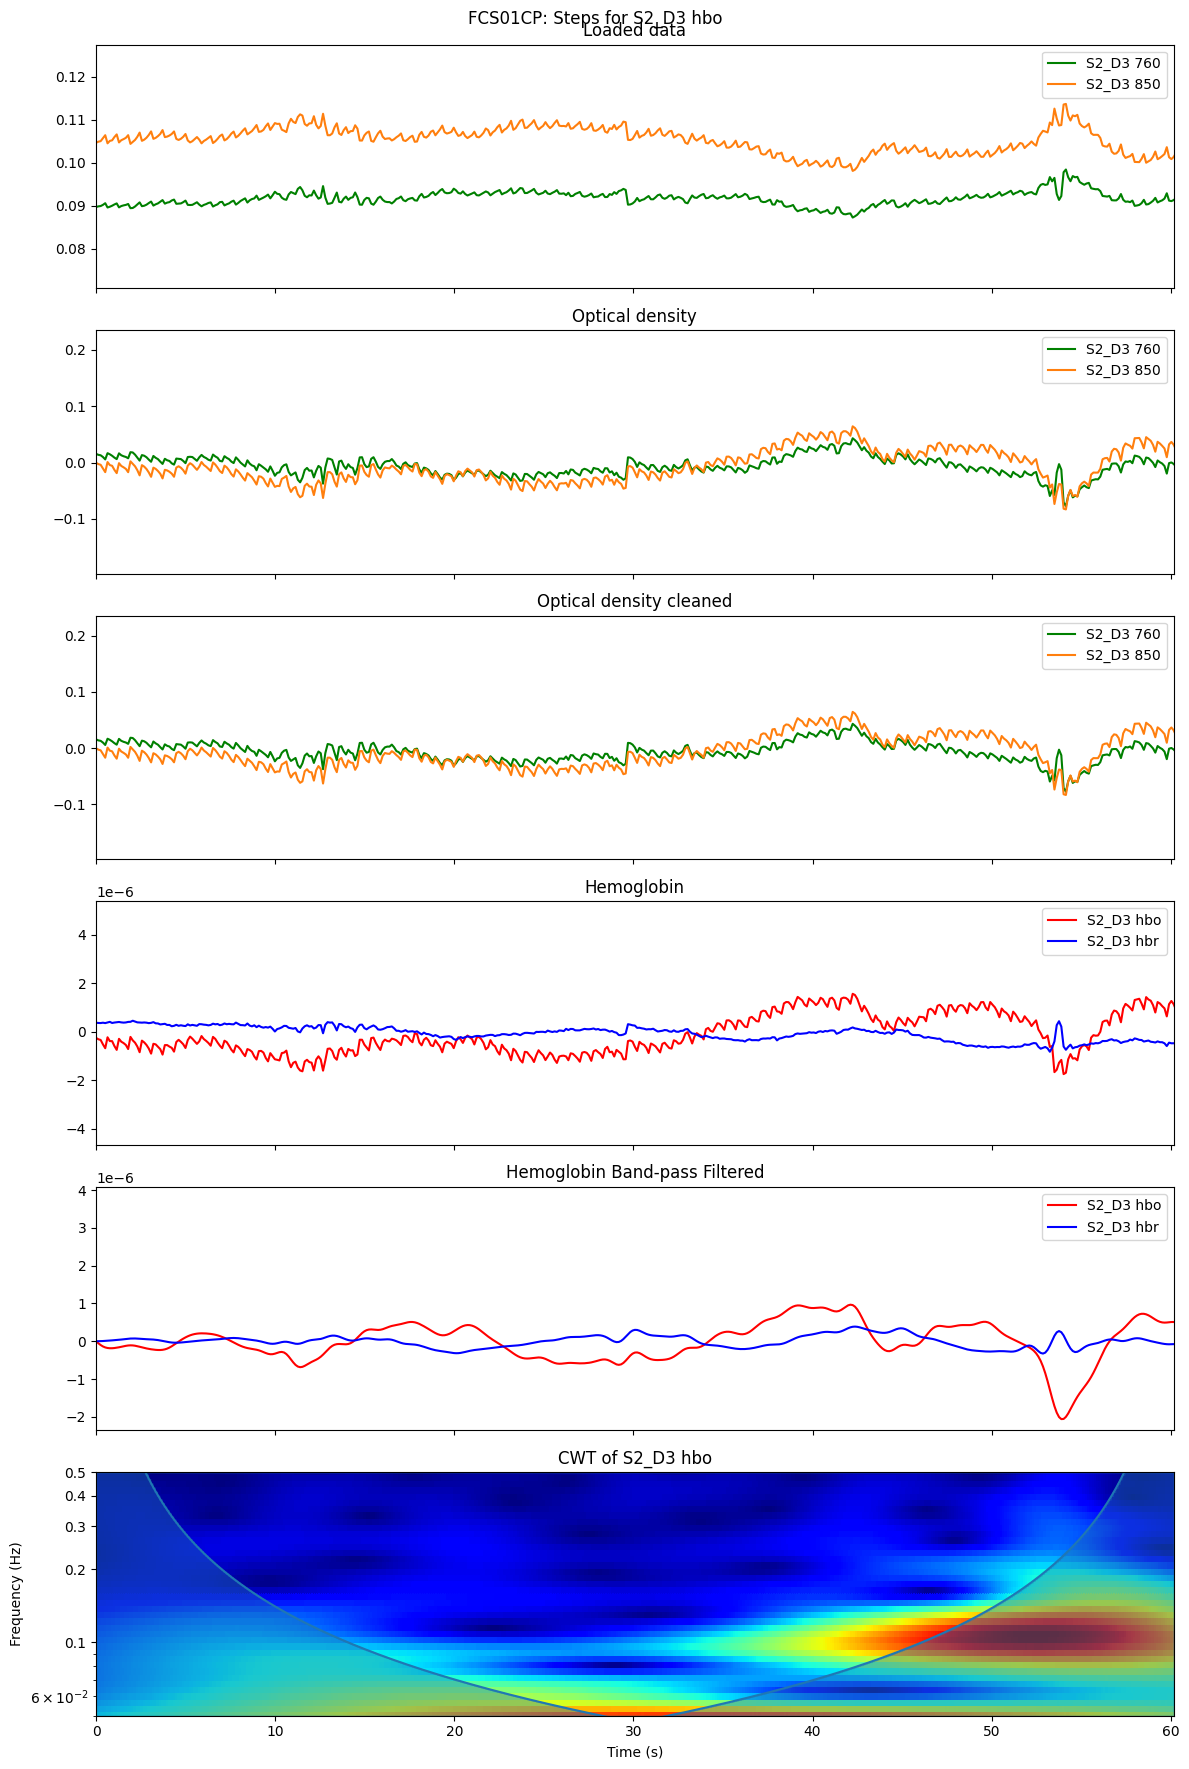

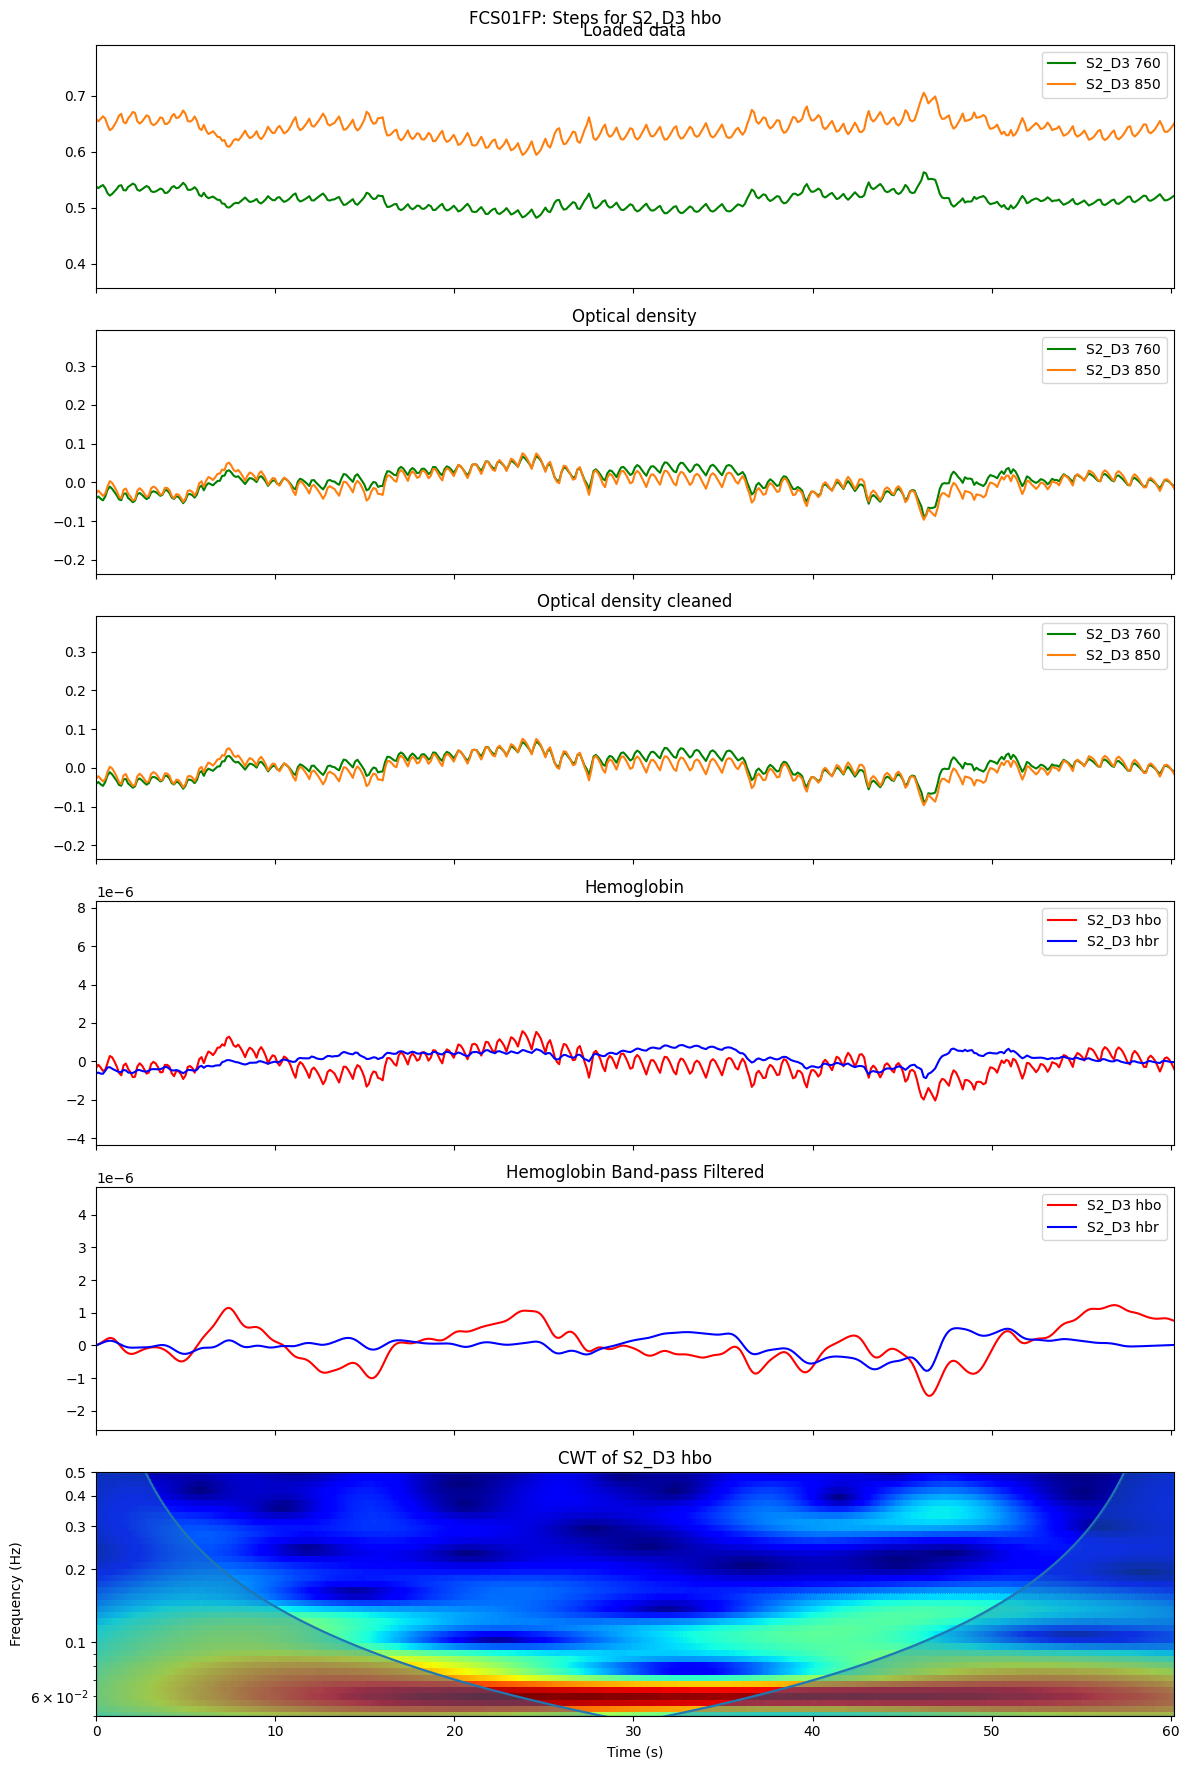

In [16]:
fig = dyad.s1.plot_steps_for_channel(wtc.label_ch1)
fig.suptitle(f"{dyad.s1.subject_label}: " + fig.get_suptitle())
plt.show()
fig = dyad.s2.plot_steps_for_channel(wtc.label_ch2)
fig.suptitle(f"{dyad.s2.subject_label}: " + fig.get_suptitle())
plt.show()

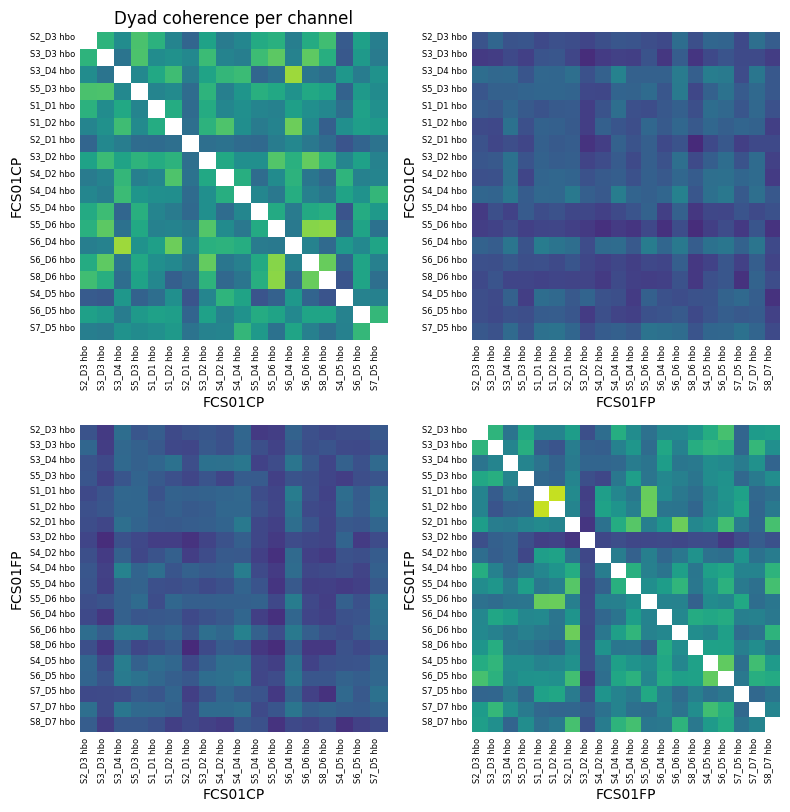

In [55]:
_ = dyad.plot_coherence_matrix_per_channel().axes[0].set_title('Dyad coherence per channel')


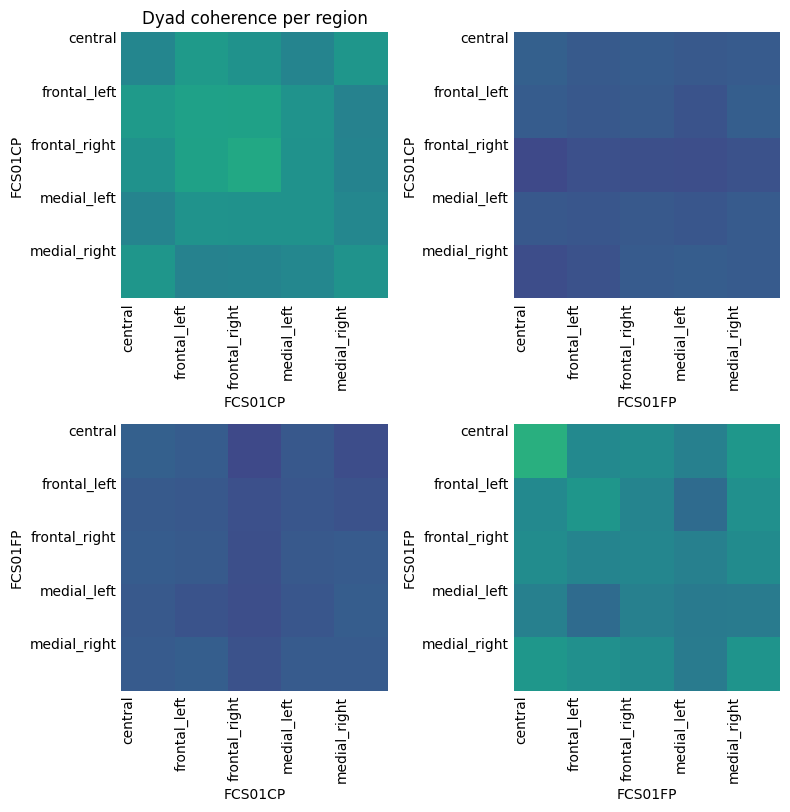

In [56]:

_ = dyad.plot_coherence_matrix_per_roi().axes[0].set_title('Dyad coherence per region')


## Study


### Study Coherence processing

We now apply the same strategy on a cohort of dyads. We define a baseline task and a sample task.

The resulting is a `Study` object, which encapsulates all the logic of processing, computing WTC and preparing pandas dataframe for analysis.

In [38]:
# Instanciate recordings and dyads objects

preprocessor = fnirs.MnePreprocessorRawToHaemo()
tasks = [
    Task('first_minute', onset_time=0, duration=60),
    Task('second_minute', onset_time=60, duration=60),
]

n_dyads = 10
all_dyads = []

# truncate for this example
dyad_paths_keys = list(dyad_paths.keys())[:n_dyads]

for dyad_key in dyad_paths_keys:
    dyad = fnirs.Dyad(
        fnirs.Recording(tasks=tasks, channel_roi=channel_roi).load_file(dyad_paths[dyad_key]['child'], preprocessor),
        fnirs.Recording(tasks=tasks, channel_roi=channel_roi).load_file(dyad_paths[dyad_key]['parent'], preprocessor),
        label=dyad_key,
    )
    all_dyads.append(dyad)

study = fnirs.Study(all_dyads)



### Wavelet object

Let's define our wavelet object. The following code simple instanciates the default wavelet. We do it explicitely for the sake of demonstration only.

The Wavelet uses caching to avoid recomputing continuous wavelet transforms all the time for the same channels.

Since the cache dictionary is shared by all dyads, a new pair with pre-computed CWT for channels will be much faster.

The cache is simply a python dictionary.


In [19]:
cache = dict()
wavelet = ComplexMorletWavelet(cache=cache)


In [ ]:
study.compute_wtcs(
    ch_match='hbo',     # compute coherence only on oxyhemoglobin channels
    wavelet=wavelet,    # use our predefined wavelet
    with_intra=True,    # compute intra subject for nicer display in quadrants
    bin_seconds=15,     # split in 10 seconds bins weight balancing. See `fnirs_wavelet_exploration.ipynb` for more details
    period_cuts=[5,10], # split frequencies in lower/higher to visualize which range has a higher coherence
    downsample=100,     # downsamples the wtc results for saving memory and allows faster display in plots
    verbose=False,      # use this flag to see the progress of processing
    # If memory usage gets too big during the processing, consider dropping the WTCs and store only the mean coherence
    #keep_wtcs=False,   # delete computed WTCs after run, to avoid storing huge files
)

Time for computing one dyad: 6 seconds
Expected time for 10 dyads: 55 seconds


### Coherence matrix

Visualize the coherence matrix averaged over all dyads. Top left and bottom right are intra-subject coherence. Bottom left and top right are mirrors of the inter-subject coherence.


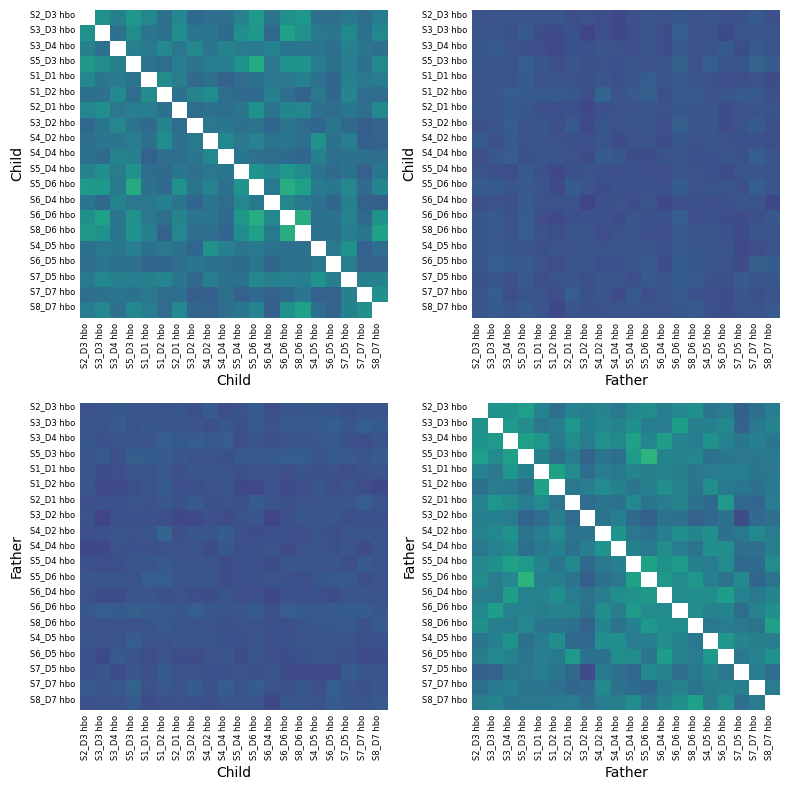

In [ ]:
_ = study.plot_coherence_matrix_per_channel(s1_label='Child', s2_label='Parent')


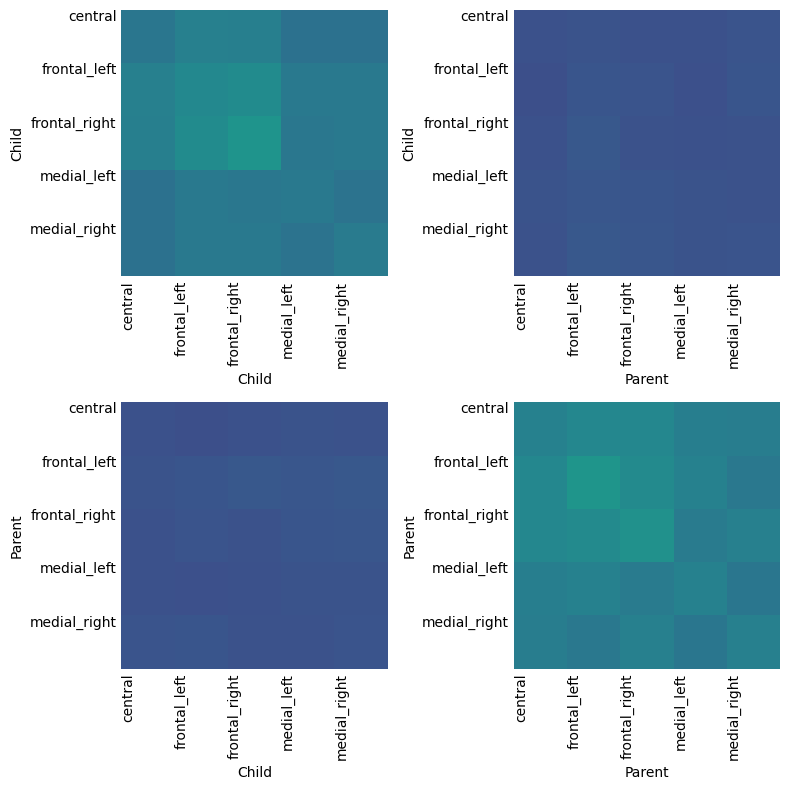

In [47]:

_ = study.plot_coherence_matrix_per_roi(s1_label='Child', s2_label='Parent')



The study object now has a pandas dataframe object that can be used or stored for further analysis


In [48]:
df = study.df[study.df['is_intra'] == False]
df


,dyad,is_intra,is_intra_of,is_pseudo,subject1,subject2,roi1,roi2,channel1,channel2,task,epoch,section,bin,coherence,coherence_masked,bin_time_range,bin_period_range,wavelet_library,wavelet_name
0,FCS01,False,NaN,False,FCS01CP,FCS01FP,frontal_left,frontal_left,S2_D3 hbo,S2_D3 hbo,first_minute,0,0,0,0.270656,0.312500,0-15,2.0-4.8,pywavelets,"cmor2,1[win:0.6]"
1,FCS01,False,NaN,False,FCS01CP,FCS01FP,frontal_left,frontal_left,S2_D3 hbo,S2_D3 hbo,first_minute,0,0,1,NaN,0.692029,0-15,5.1-9.8,pywavelets,"cmor2,1[win:0.6]"
2,FCS01,False,NaN,False,FCS01CP,FCS01FP,frontal_left,frontal_left,S2_D3 hbo,S2_D3 hbo,first_minute,0,0,2,NaN,1.000000,0-15,10.4-20.0,pywavelets,"cmor2,1[win:0.6]"
3,FCS01,False,NaN,False,FCS01CP,FCS01FP,frontal_left,frontal_left,S2_D3 hbo,S2_D3 hbo,first_minute,0,0,3,0.151859,0.000000,15-30,2.0-4.8,pywavelets,"cmor2,1[win:0.6]"
4,FCS01,False,NaN,False,FCS01CP,FCS01FP,frontal_left,frontal_left,S2_D3 hbo,S2_D3 hbo,first_minute,0,0,4,0.427183,0.000000,15-30,5.1-9.8,pywavelets,"cmor2,1[win:0.6]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172075,FCS10,False,NaN,False,FCS10CP,FCS10FP,medial_right,medial_right,S8_D7 hbo,S8_D7 hbo,second_minute,0,0,7,0.188210,0.000000,30-44,5.1-9.8,pywavelets,"cmor2,1[win:0.6]"
172076,FCS10,False,NaN,False,FCS10CP,FCS10FP,medial_right,medial_right,S8_D7 hbo,S8_D7 hbo,second_minute,0,0,8,0.442469,0.336957,30-44,10.4-20.0,pywavelets,"cmor2,1[win:0.6]"
172077,FCS10,False,NaN,False,FCS10CP,FCS10FP,medial_right,medial_right,S8_D7 hbo,S8_D7 hbo,second_minute,0,0,9,0.173053,0.225543,44-59,2.0-4.8,pywavelets,"cmor2,1[win:0.6]"
172078,FCS10,False,NaN,False,FCS10CP,FCS10FP,medial_right,medial_right,S8_D7 hbo,S8_D7 hbo,second_minute,0,0,10,NaN,0.605072,44-59,5.1-9.8,pywavelets,"cmor2,1[win:0.6]"


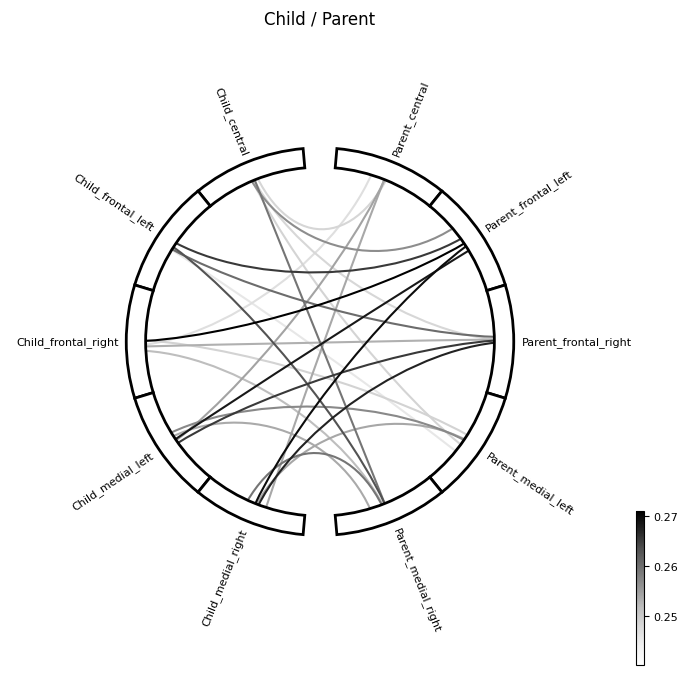

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': 'polar'})
_ = study.plot_coherence_connectogram(s1_label='Child', s2_label='Parent', ax=ax)


### Save to disk

Multiple formats can be used to save the results to disk. 

| Format | Use case |
| - | - |
| `.csv` | Typical CSV file with a header, for sharing and importing in another python script or an external analysis software |
| `.feather` | Typical pandas dataframe storage format, for further analysis |
| `.pickle` | Used to reload the `Study` object for visualisation in a dashboard. |



In [ ]:
csv_file_path = '../data/results/fnirs_study_example.csv'
study.save_csv(csv_file_path)


In [ ]:
feather_file_path = '../data/results/fnirs_study_example.feather'
study.save_feather(feather_file_path)


In [ ]:
# Save to disk

results_file_path = '../data/results/fnirs_study_example.pickle'
study.save_pickle(results_file_path)
